In [23]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("wine_data_outliers_removed.csv")
pca = PCA(n_components=3)
standard_scalar = StandardScaler()
pipeline = make_pipeline(standard_scalar, pca)
print(data.head())
data_without_quality_var = data.drop(columns=['Unnamed: 0','quality'])
pipeline.fit_transform(data_without_quality_var)
explained_variance = pca.explained_variance_ratio_

   Unnamed: 0  fixed acidity  volatile acidity  citric acid  residual sugar  \
0           0            7.0              0.27         0.36            20.7   
1           1            6.3              0.30         0.34             1.6   
2           2            8.1              0.28         0.40             6.9   
3           3            7.2              0.23         0.32             8.5   
4           4            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  colour  
0       0.45      8.8        6       0 

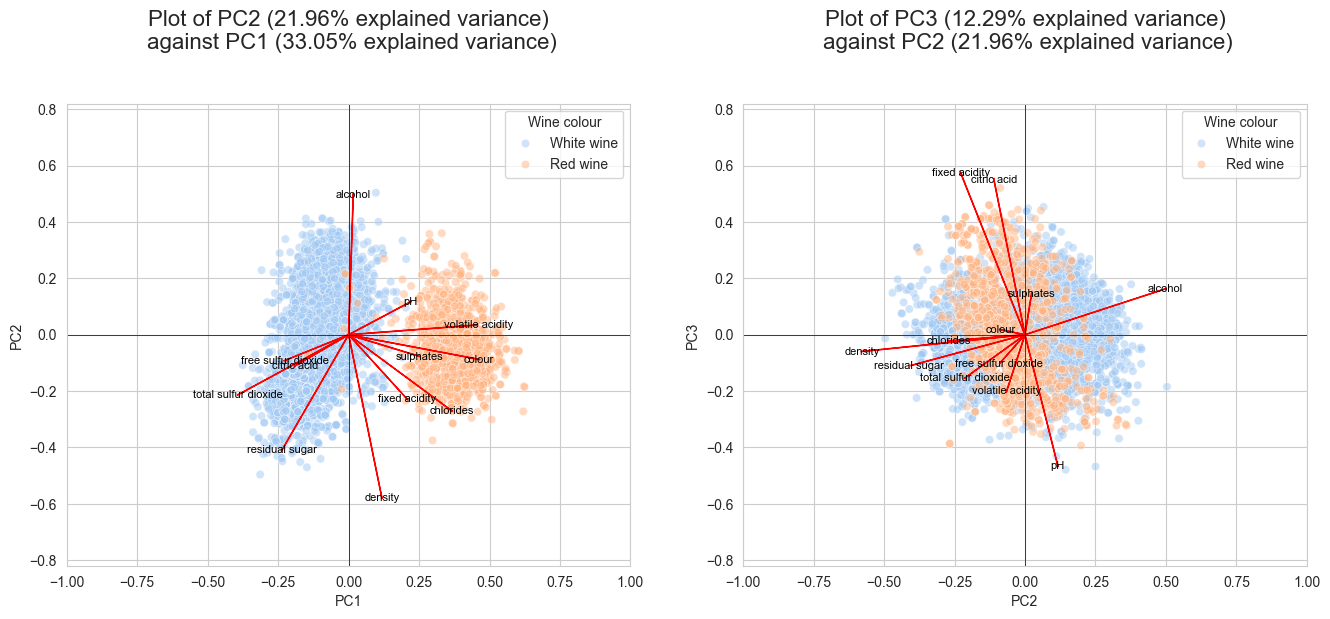

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

'''
A function to produce biplots for PCA components. Assumes data has already been fitted with a pipeline and is available as wine_data_all. Values for fit and pca are passed in because different scopes enforce the use of references and not modifying the original fit
'''
sns.set_palette("pastel")

def biplot_for_pca(pipeline_fit: object, pca_fit: PCA, pca_number_for_x_axis: int, pca_number_for_y_axis: int,
                   plot_title_fig_1: str, figure_file_name: str, plot_title_fig_2) -> None:
    fig, ax = plt.subplots(figsize=(16, 6), ncols=2)
    ax[0].grid(True)
    ax[1].grid(True)

    for axis_index, pca_number in enumerate([pca_number_for_x_axis, pca_number_for_y_axis]):
        ax[axis_index].axis("equal")
        ax[axis_index].set_xlim(-1, 1)
        ax[axis_index].set_ylim(-1, 1)
        ax[axis_index].set_xlabel(f"PC{pca_number}")
        ax[axis_index].set_ylabel(f"PC{pca_number + 1}")
        if axis_index == 0:
            ax[axis_index].set_title(plot_title_fig_1, fontsize=16, y=1.1)
        else:
            ax[axis_index].set_title(plot_title_fig_2, fontsize=16, y=1.1)
        # Extract transformed values from fit for x and y axes
        pca_data_index_x = pca_number - 1
        pca_data_index_y = pca_number + 1 - 1
        pca_data_x = pipeline_fit.transform(data_without_quality_var)[:, pca_data_index_x]
        pca_data_y = pipeline_fit.transform(data_without_quality_var)[:, pca_data_index_y]
        coeff = np.transpose(pca_fit.components_[pca_data_index_x:pca_data_index_y + 1, :])
        n = data_without_quality_var.shape[1]
        scale_x_axis = 1.0 / (pca_data_x.max() - pca_data_x.min())
        scale_y_axis = 1.0 / (pca_data_y.max() - pca_data_y.min())

        # Used for differentiating the wine type
        sns.scatterplot(x=pca_data_x * scale_x_axis, y=pca_data_y * scale_y_axis,
                        hue=data_without_quality_var['colour'], alpha=0.5, ax=ax[axis_index])

        # Generate the legend

        legend = ax[axis_index].legend(title='Wine colour', loc='upper right')
        legend.get_texts()[0].set_text("White wine")
        legend.get_texts()[1].set_text("Red wine")

        for column_index in range(n):
            x_position = coeff[column_index, 0]
            y_position = coeff[column_index, 1]

            # Check if the label will overlap with others, and adjust position if needed
            if column_index < n - 1:
                for j in range(column_index + 1, n):
                    if (abs(x_position - coeff[j, 0]) < 0.1) and (abs(y_position - coeff[j, 1]) < 0.1):
                        x_position += 0.1
                        y_position += 0.1

            label = data_without_quality_var.T.index[column_index]

            # # Find the last space character and replace it with a newline
            # last_space_index = label.rfind(" ")
            # if last_space_index >= 0:
            #     # Add an extra new line for total sulfur dioxide so labels don't overlap
            #     if pca_data_index_y == 4 and column_index == 6:
            #         label = label[:last_space_index] + "\n\n" + label[last_space_index + 1:]
            #     label = label[:last_space_index] + "\n" + label[last_space_index + 1:]

            ax[axis_index].arrow(0, 0, x_position, y_position, color="r")
            # Add arrowheads to labels
            ax[axis_index].annotate(label, (x_position, y_position), color="black",
                                    arrowprops=dict(arrowstyle="->", lw=1.5),
                                    fontsize=8, ha='center', va='center')

        ax[axis_index].axhline(0, color='black', linewidth=0.5)  # Add horizontal line
        ax[axis_index].axvline(0, color='black', linewidth=0.5)  # Add vertical line

    fig.savefig(figure_file_name, dpi=300, bbox_inches='tight')


# PCA numbers are between 1 and 3, so we just need range 1 to 2, with 3 being 2 + 1.  
explained_variance_percentage = ["{:.2%}".format(num) for num in pca.explained_variance_ratio_]
for pca_number in range(1, 2):
    # Create a new PCA object for each plot
    biplot_for_pca(pipeline.fit(data_without_quality_var), pca, pca_number, pca_number + 1,
                   f"Plot of PC{pca_number + 1} ({explained_variance_percentage[pca_number]} explained variance)\n against PC{pca_number} ({explained_variance_percentage[pca_number - 1]} explained variance)",
                   "biplots_combined_no_quality_new.png",
                   f"Plot of PC{pca_number + 2} ({explained_variance_percentage[pca_number + 1]} explained variance)\n against PC{pca_number+1} ({explained_variance_percentage[pca_number]} explained variance)")

In [18]:
pca.components_
data_without_quality_var

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,colour
0,0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,0
1,1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,0
2,2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,0
3,3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,0
4,4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6039,6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,1
6040,6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,1
6041,6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,1
6042,6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,1
